# Regression
This material is adapted from the following,
- [Scikit Learn](http://scikit-learn.org/stable/)  
- [Sebastian Raschka](https://github.com/rasbt/python-machine-learning-book)  
- [Jake Vanderplas](https://github.com/jakevdp/sklearn_tutorial)
- [Andreas Mueller](http://amueller.github.io)  
- [Kyle Kastner](https://kastnerkyle.github.io/)  
- [Quantopian Research](https://github.com/quantopian/research_public)
- [Python for Probability, Statistics, and Machine Learning](http://www.springer.com/fr/book/9783319307152), [github](https://github.com/unpingco/Python-for-Probability-Statistics-and-Machine-Learning)

## Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext line_profiler
%matplotlib inline

# Ignore Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from helper_functions import tic, toc

""" Include Parent Directory in Python Path """
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from IPython.display import Image

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Simple Linear Regression

Linear regression is a technique that measures the relationship between two variables. If we have an independent variable $X$, and a dependent outcome variable $Y$, linear regression allows us to determine which linear model $Y = \alpha + \beta X$ best explains the data.

## Ordinary Least Squares

Regression works by optimizing the placement of the line of best fit (or plane in higher dimensions). It does so by defining how bad the fit is using an objective function. In ordinary least squares regression (OLS), what we use here, the objective function is:

$$\sum_{i=1}^n (Y_i - a - bX_i)^2$$

We use $a$ and $b$ to represent the potential candidates for $\alpha$ and $\beta$. What this objective function means is that for each point on the line of best fit we compare it with the real point and take the square of the difference. This function will decrease as we get better parameter estimates. Regression is a simple case of numerical optimization that has a closed form solution and does not need any optimizer. We just find the results that minimize the objective function.

We will denote the eventual model that results from minimizing our objective function as:

$$ \hat{Y} = \hat{\alpha} + \hat{\beta}X $$

With $\hat{\alpha}$ and $\hat{\beta}$ being the chosen estimates for the parameters that we use for prediction and $\hat{Y}$ being the predicted values of $Y$ given the estimates.

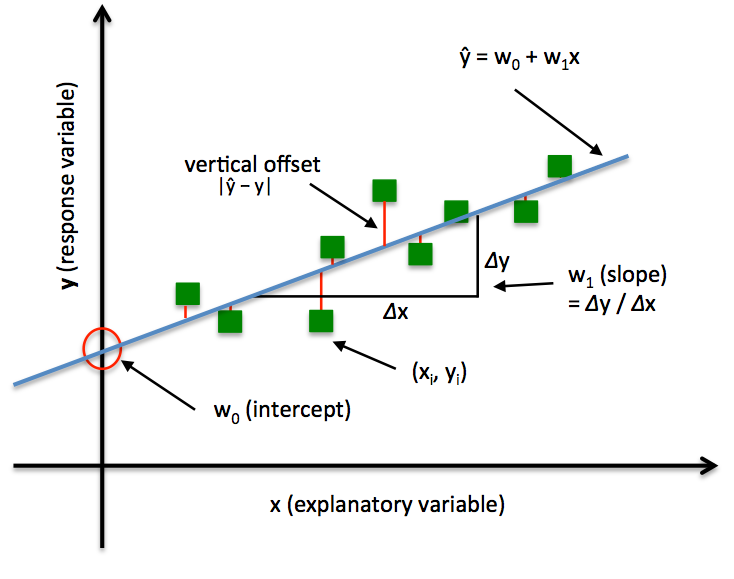

In [3]:
Image(filename='../images/10_01.png', width=500) 

# Exploring the Housing dataset
## Pay attention because this is related to your Kaggle competition!

Source: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Attributes:
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's
</pre>

In [4]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Visualizing the important characteristics of a dataset

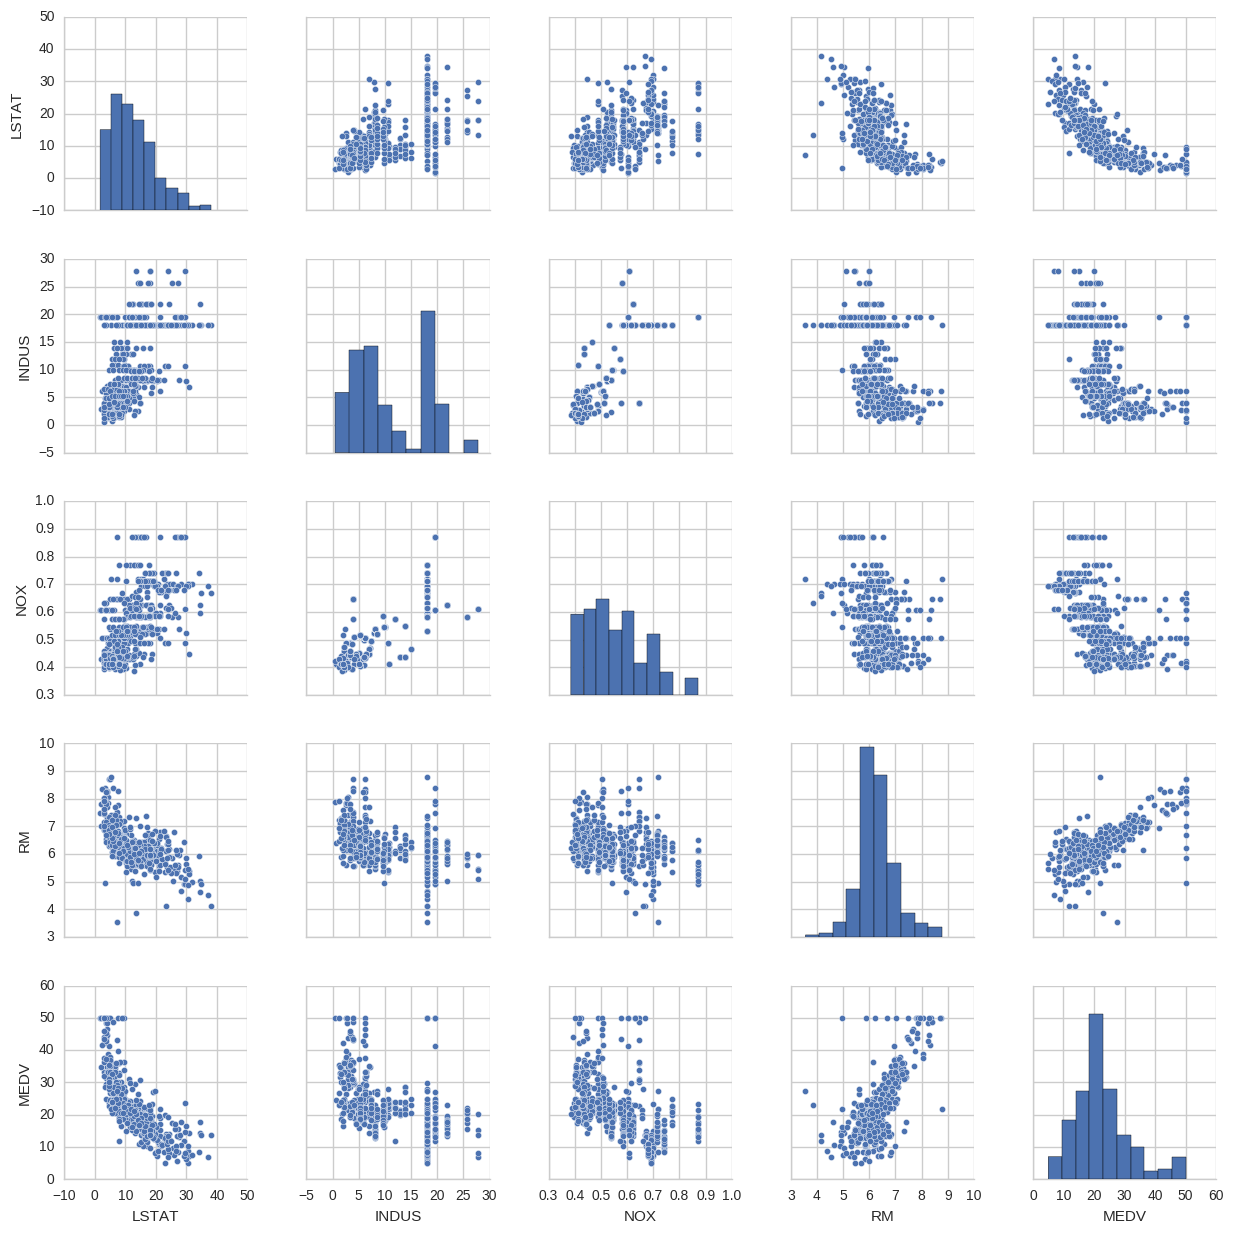

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()

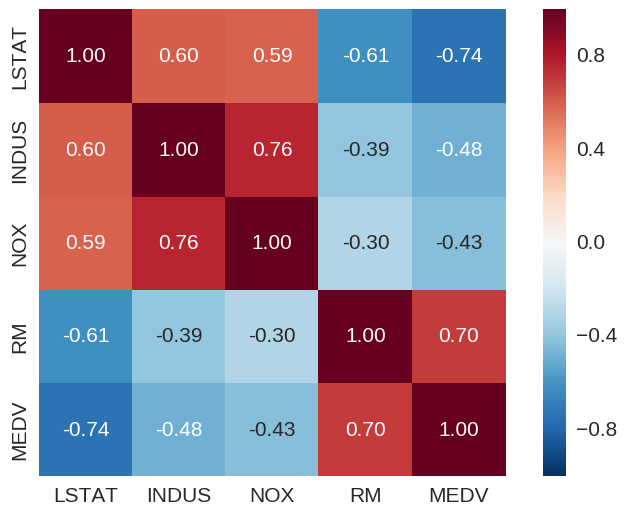

In [6]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()

## Solving for regression parameters with gradient descent

In [7]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [8]:
X = df[['RM']].values
y = df['MEDV'].values

In [9]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [10]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

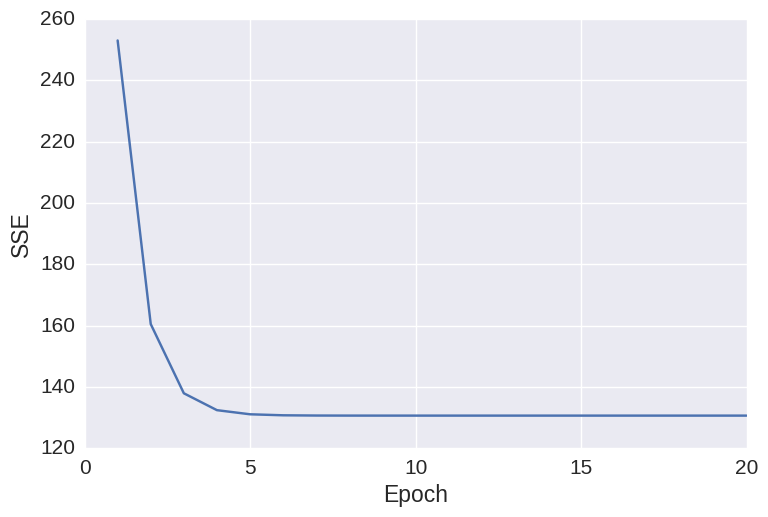

In [11]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()

In [12]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

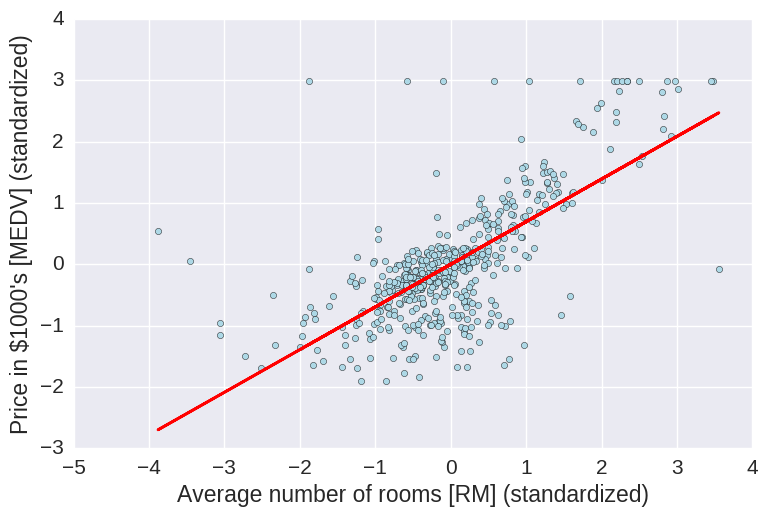

In [13]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()

In [14]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [15]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


## Estimating the coefficient of a regression model via scikit-learn

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


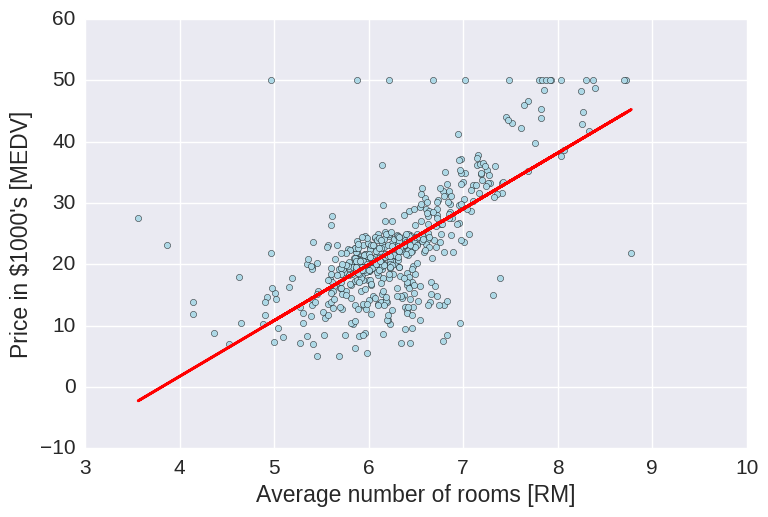

In [18]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()

**Normal Equations** alternative:

In [19]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


## Statsmodels
Python's `statsmodels` library has a built-in linear fit function. Note that this will give a line of best fit; whether or not the relationship it shows is significant is for you to determine. The output will also have some statistics about the model, such as R-squared and the F value, which may help you quantify how good the fit actually is.

In [20]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

In [21]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Thu, 19 Jan 2017   Prob (F-statistic):           2.49e-74
Time:                        07:51:49   Log-Likelihood:                -550.82
No. Observations:                 506   AIC:                             1106.
Df Residuals:                     504   BIC:                             1114.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -5.638e-16      0.032  -1.76e-14      1.000        -0.063     0.063
x1             0.6954      0.032     21.722      0.000         0.632     0.758
==============================================================================
Omnibus:                      102.585   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.449
Skew:                           0.726   Prob(JB):                    1.02e-133
Kurtosis:                       8.190   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

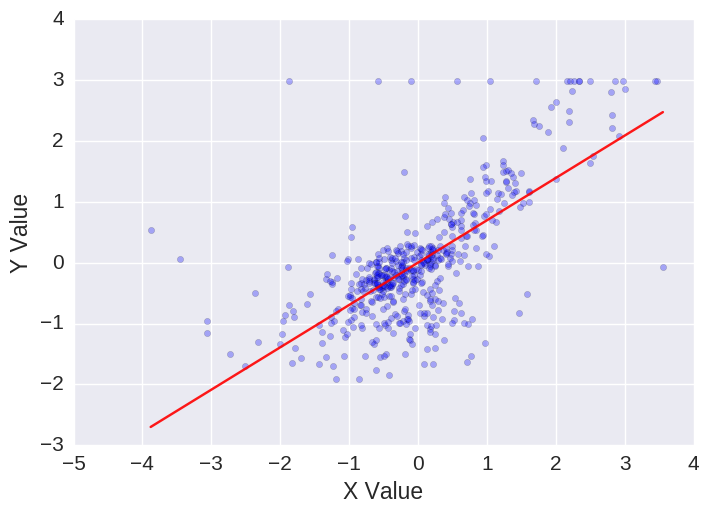

In [22]:
linreg(X_std, y_std)

# Fitting a robust regression model using RANSAC

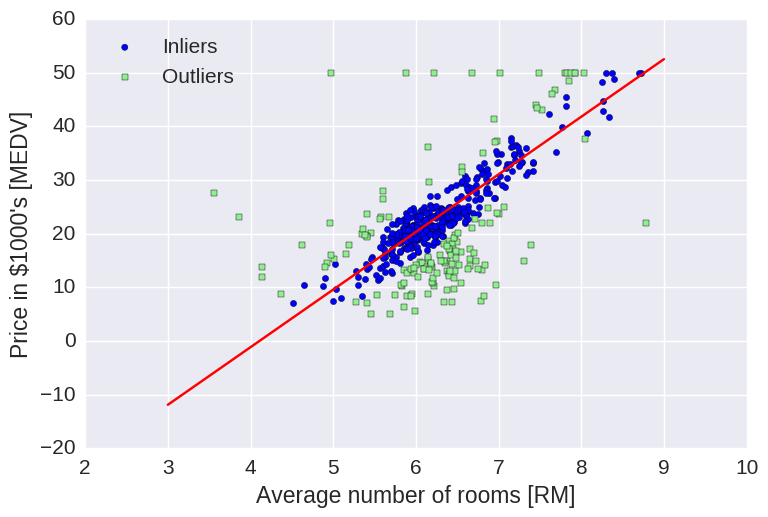

In [23]:
from sklearn.linear_model import RANSACRegressor

if Version(sklearn_version) < '0.18':
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                             residual_threshold=5.0, 
                             random_state=0)
else:
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             loss='absolute_loss', 
                             residual_threshold=5.0, 
                             random_state=0)


ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()

In [24]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


# Evaluating and reporting results

The regression model relies on several assumptions:
* The independent variable is not random.
* The variance of the error term is constant across observations. This is important for evaluating the goodness of the fit.
* The errors are not autocorrelated. The Durbin-Watson statistic detects this; if it is close to 2, there is no autocorrelation.
* The errors are normally distributed. If this does not hold, we cannot use some of the statistics, such as the F-test.

If we confirm that the necessary assumptions of the regression model are satisfied, we can safely use the statistics reported to analyze the fit. For example, the $R^2$ value tells us the fraction of the total variation of $Y$ that is explained by the model.

When making a prediction based on the model, it's useful to report not only a single value but a confidence interval. The linear regression reports 95% confidence intervals for the regression parameters, and we can visualize what this means using the `seaborn` library, which plots the regression line and highlights the 95% (by default) confidence interval for the regression line:

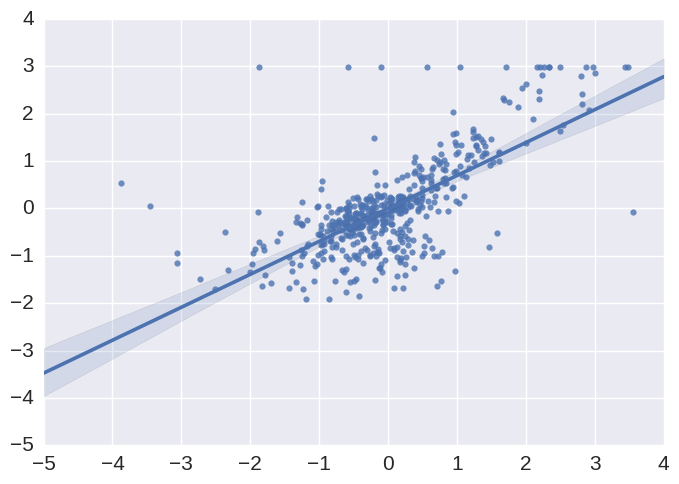

In [25]:
sns.regplot(X_std, y_std)

## Parameters vs. Estimates

It is very important to keep in mind that all $\alpha$ and $\beta$ parameters estimated by linear regression are just that - estimates. You can never know the underlying true parameters unless you know the physical process producing the data. The paremeters you estimate today may not be the same as the same analysis done including tomorrow's data, and the underlying true parameters may be moving. As such it is very important when doing actual analysis to pay attention to the standard error of the parameter estimates. More material on the standard error will be presented in a later lecture. One way to get a sense of how stable your paremeter estimates are is to estimates them using a rolling window of data and see how much variance there is in the estimates.


## Linear Regression vs. Correlation

* Linear regression gives us a specific linear model, but is limited to cases of linear dependence.
* Correlation is general to linear and non-linear dependencies, but doesn't give us an actual model.
* Both are measures of covariance.
* Linear regression can give us relationship between Y and many independent variables by making X multidimensional.

## The Correlation Coefficient
The correlation coefficient measures the extent to which the relationship between two variables is linear. Its value is always between -1 and 1. A positive coefficient indicates that the variables are directly related, i.e. when one increases the other one also increases. A negative coefficient indicates that the variables are inversely related, so that when one increases the other decreases. The closer to 0 the correlation coefficient is, the weaker the relationship between the variables.

The correlation coefficient of two series $X$ and $Y$ is defined as
$$r = \frac{Cov(X,Y)}{std(X)std(Y)}$$
where $Cov$ is the covariance and $std$ is the standard deviation.

Two random sets of data will have a correlation coefficient close to 0:

## Correlation vs. Covariance

Correlation is simply a normalized form of covariance. They are otherwise the same and are often used semi-interchangeably in everyday conversation. It is obviously important to be precise with language when discussing the two, but conceptually they are almost identical.

###Covariance isn't that meaningful by itself

Let's say we have two variables $X$ and $Y$ and we take the covariance of the two.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
X = np.random.rand(50)
Y = 2 * X + np.random.normal(0, 0.1, 50)

np.cov(X, Y)[0, 1]

0.13057845206992322

So now what? What does this mean? Correlation uses information about the variance of X and Y to normalize this metric. Once we've normalized the metric to the -1 to 1 scale, we can make meaningful statements and compare correlations.

To see how this is done consider the formula.

$$\frac{Cov(X, Y)}{std(X)std(Y)}$$

$$= \frac{Cov(X, Y)}{\sqrt{var(X)}\sqrt{var(Y)}}$$

$$= \frac{Cov(X, Y)}{\sqrt{Cov(X, X)}\sqrt{Cov(Y, Y)}}$$

To demonstrate this let's compare the correlation and covariance of two series.

In [28]:
X = np.random.rand(50)
Y = 2 * X + 4

print ('Covariance of X and Y: \n' + str(np.cov(X, Y)))
print ('Correlation of X and Y: \n' + str(np.corrcoef(X, Y)))

Covariance of X and Y: 
[[ 0.07728824  0.15457649]
 [ 0.15457649  0.30915297]]
Correlation of X and Y: 
[[ 1.  1.]
 [ 1.  1.]]


## Why do both `np.cov` and `np.corrcoef` return matricies?

The covariance matrix is an important concept in statistics. Often people will refer to the covariance of two variables $X$ and $Y$, but in reality that is just one entry in the covariance matrix of $X$ and $Y$. For each input variable we have one row and one column. The diagonal is just the variance of that variable, or $Cov(X, X)$, entries off the diagonal are covariances between different variables. The matrix is symmetric across the diagonal. Let's check that this is true.

In [29]:
cov_matrix = np.cov(X, Y)

# We need to manually set the degrees of freedom on X to 1, as numpy defaults to 0 for variance
# This is usually fine, but will result in a slight mismatch as np.cov defaults to 1
error = cov_matrix[0, 0] - X.var(ddof=1)

print ('error: ' + str(error))

error: -1.38777878078e-17


Correlation: -0.0224607520593
Built-in Correlation: -0.0220115370181


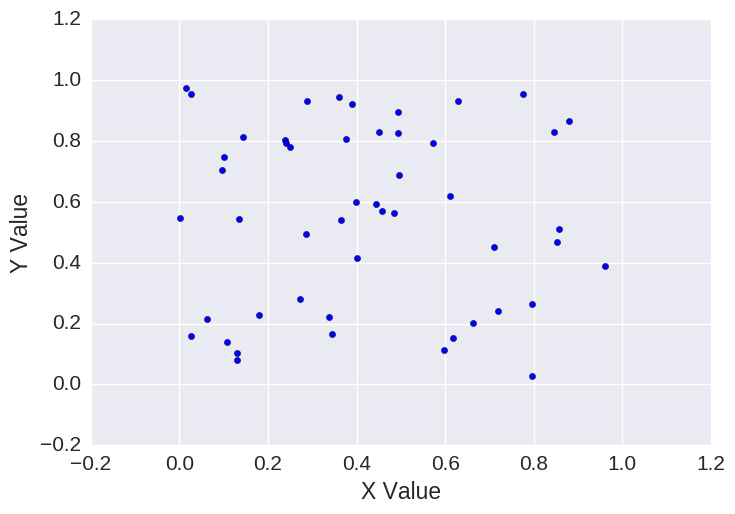

In [30]:
X = np.random.rand(50)
Y = np.random.rand(50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

# taking the relevant value from the matrix returned by np.cov
print ('Correlation: ' + str(np.cov(X,Y)[0,1]/(np.std(X)*np.std(Y))))
# Let's also use the builtin correlation function
print ('Built-in Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

Now let's see what two correlated sets of data look like.

Correlation: 0.946673228128


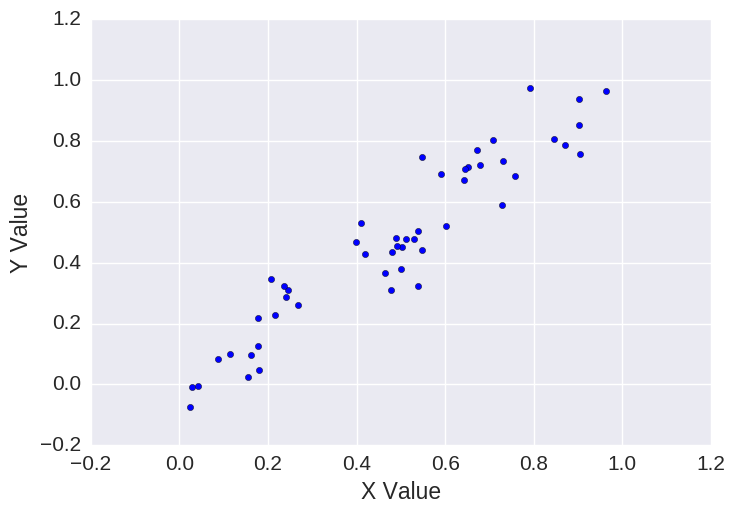

In [31]:
X = np.random.rand(50)
Y = X + np.random.normal(0, 0.1, 50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print ('Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

Let's dial down the relationship by introducing more noise.

Correlation: 0.873063889502


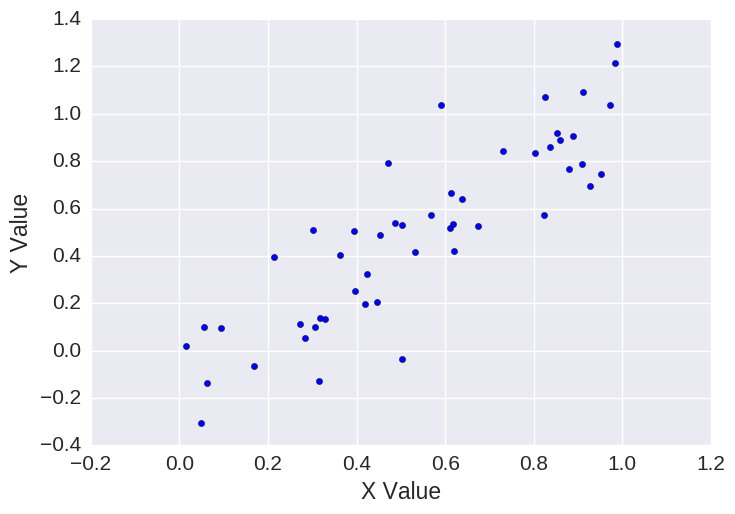

In [32]:
X = np.random.rand(50)
Y = X + np.random.normal(0, .2, 50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print ('Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

Finally, let's see what an inverse relationship looks like.

Correlation: -0.946404802991


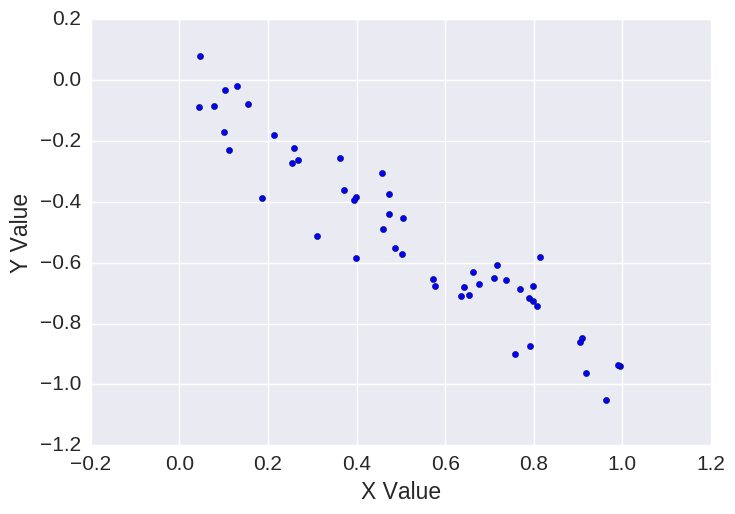

In [33]:
X = np.random.rand(50)
Y = -X + np.random.normal(0, .1, 50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print ('Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

# Limitations

## Significance

It's hard to rigorously determine whether or not a correlation is significant, especially when, as here, the variables are not normally distributed. Correlation is a powerful technique, but as always in statistics, one should be careful not to interpret results where there are none.

One fundamental problem is that it is easy to datamine correlations by picking the right subset of data. To avoid this, one should compute the correlation of two quantities over many subsets and examine the distibution of the correlation coefficient.

As an example, consider the correlation of the following time series:

In [34]:
import pandas_datareader.data as web
import datetime

In [35]:
# Pull the pricing data for our two stocks and S&P 500
start = datetime.datetime(2013,1,1)
end = datetime.datetime(2015,1,1)
bench = web.DataReader('SPY', 'yahoo', start=start, end=end)
a1 = web.DataReader('LRCX', 'yahoo', start=start, end=end)
a2 = web.DataReader('AAPL', 'yahoo', start=start, end=end)

Correlation coefficients
LRCX and AAPL:  -0.780997533404
LRCX and SPY:  0.935203512322
AAPL and SPY:  -0.589906301841


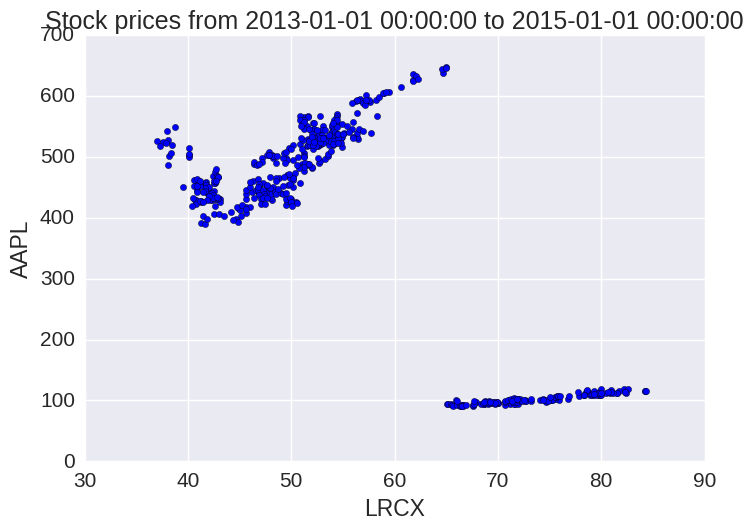

In [36]:
plt.scatter(a1['Close'],a2['Close'])
plt.xlabel('LRCX')
plt.ylabel('AAPL')
plt.title('Stock prices from ' + str(start) + ' to ' + str(end))
print ("Correlation coefficients")
print ("LRCX and AAPL: ", np.corrcoef(a1['Close'],a2['Close'])[0,1])
print ("LRCX and SPY: ", np.corrcoef(a1['Close'],bench['Close'])[0,1])
print ("AAPL and SPY: ", np.corrcoef(bench['Close'],a2['Close'])[0,1])

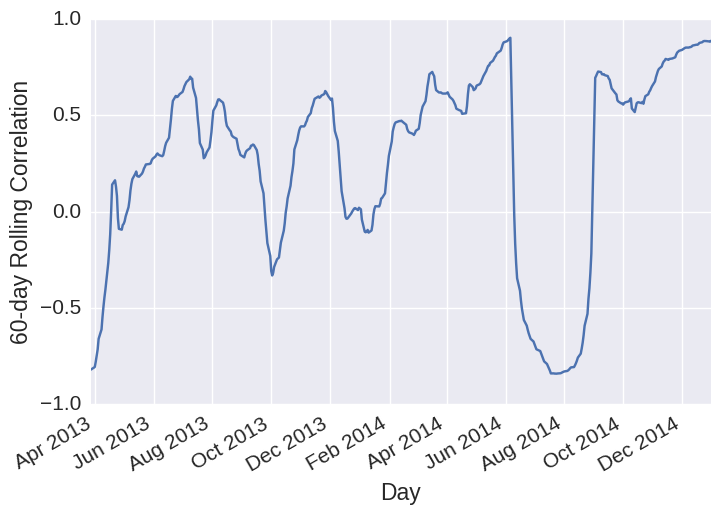

In [37]:
rolling_correlation = pd.rolling_corr(a1['Close'], a2['Close'], 60)

fig,ax = plt.subplots()
plt.plot(rolling_correlation)
plt.xlabel('Day')
plt.ylabel('60-day Rolling Correlation')
fig.autofmt_xdate()

## Non-Linear Relationships

The correlation coefficient can be useful for examining the strength of the relationship between two variables. However, it's important to remember that two variables may be associated in different, predictable ways which this analysis would not pick up. For instance, one variable might precisely follow the behavior of a second, but with a delay. There are techniques for dealing with this lagged correlation. Alternatively, a variable may be related to the rate of change of another. Neither of these relationships are linear, but can be very useful if detected.

Additionally, the correlation coefficient can be very sensitive to outliers. This means that including or excluding even a couple of data points can alter your result, and it is not always clear whether these points contain information or are simply noise.

As an example, let's make the noise distribution poisson rather than normal and see what happens.

0.2330944658121577

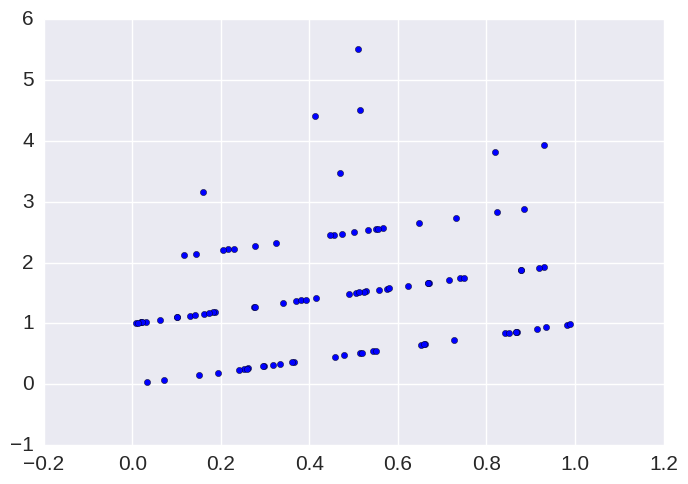

In [38]:
X = np.random.rand(100)
Y = X + np.random.poisson(size=100)

plt.scatter(X, Y)

np.corrcoef(X, Y)[0, 1]

## Standard Error

We can also find the standard error of estimate, which measures the standard deviation of the error term $\epsilon$, by getting the `scale` parameter of the model returned by the regression and taking its square root. The formula for standard error of estimate is
$$ s = \left( \frac{\sum_{i=1}^n \epsilon_i^2}{n-2} \right)^{1/2} $$

If $\hat{\alpha}$ and $\hat{\beta}$ were the true parameters ($\hat{\alpha} = \alpha$ and $\hat{\beta} = \beta$), we could represent the error for a particular predicted value of $Y$ as $s^2$ for all values of $X_i$. We could simply square the difference $(Y - \hat{Y})$ to get the variance because $\hat{Y}$ incorporates no error in the paremeter estimates themselves. Because $\hat{\alpha}$ and $\hat{\beta}$ are merely estimates in our construction of the model of $Y$, any predicted values , $\hat{Y}$, will have their own standard error based on the distribution of the $X$ terms that we plug into the model. This forecast error is represented by the following:

$$ s_f^2 = s^2 \left( 1 + \frac{1}{n} + \frac{(X - \mu_X)^2}{(n-1)\sigma_X^2} \right) $$

where $\mu_X$ is the mean of our observations of $X$ and $\sigma_X$ is the standard deviation of $X$. This adjustment to $s^2$ incorporates the uncertainty in our parameter estimates. Then the 95% confidence interval for the prediction is $\hat{Y} \pm t_cs_f$, where $t_c$ is the critical value of the t-statistic for $n$ samples and a desired 95% confidence.

In [39]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [40]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

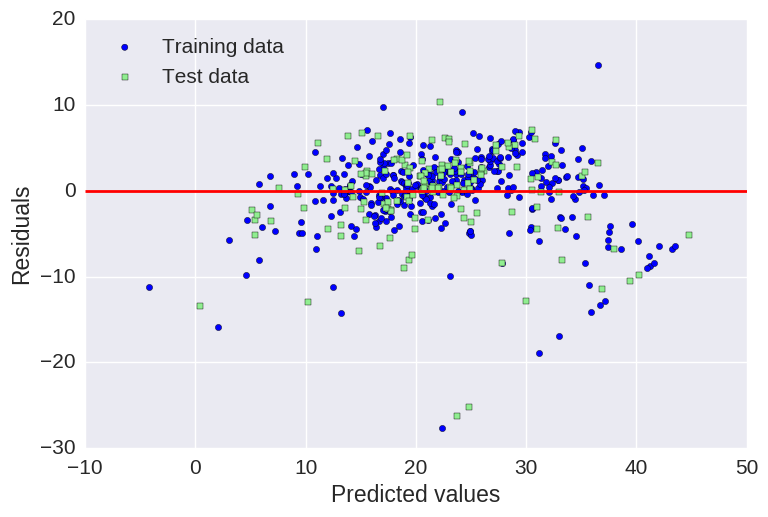

In [41]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

In [42]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


# Using regularized methods for regression

In [43]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


In [44]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


# Turning a linear regression model into a curve - polynomial regression

In [45]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [46]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

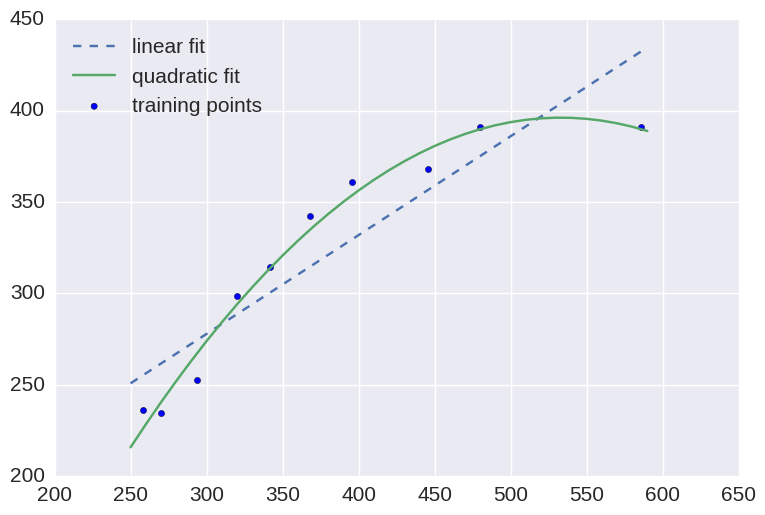

In [47]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()

In [48]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [49]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing Dataset

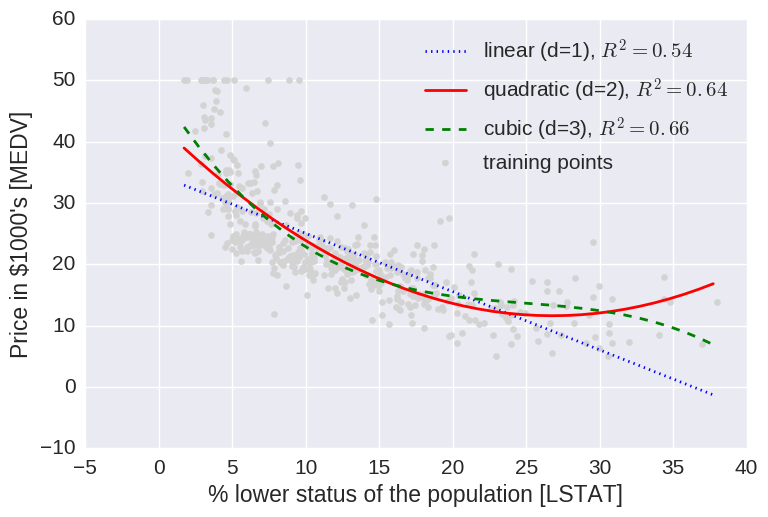

In [50]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

Transforming the dataset:

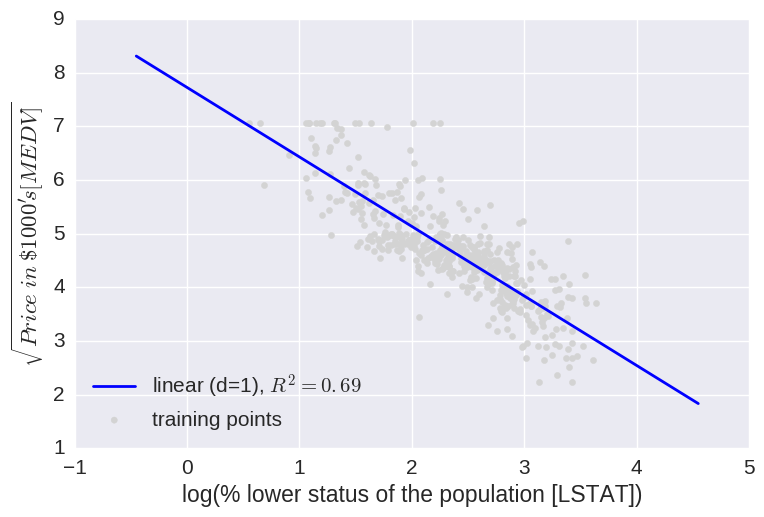

In [51]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

# Dealing with nonlinear relationships using random forests

## Decision tree regression

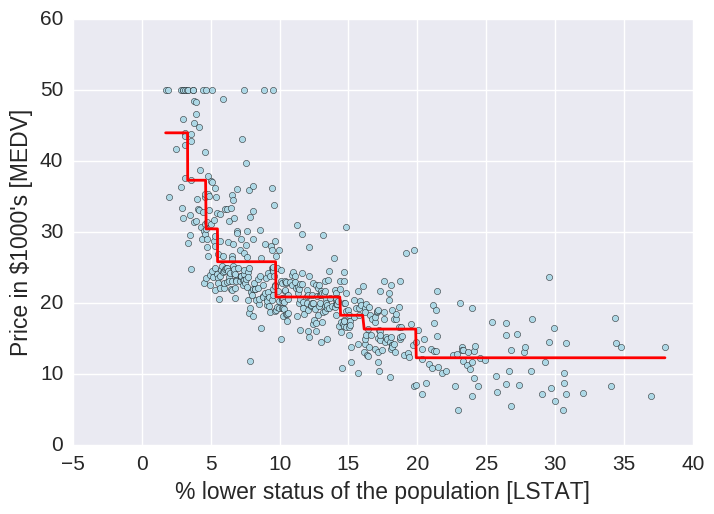

In [52]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

## Random forest regression

In [53]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


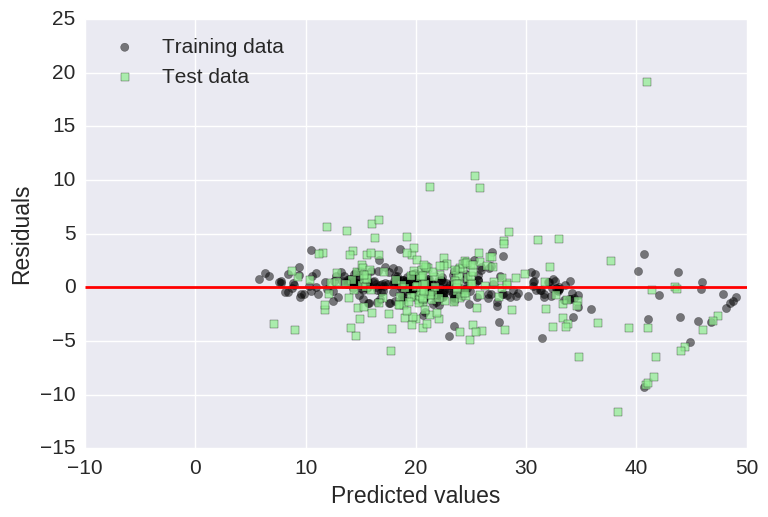

In [55]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

# Residual Analysis

When using a regression to fit a model to our data, the assumptions of regression analysis myst be satisfied in order to ensure good parameter estimates and accurate fit statistics. We would like parameters to be:

    unbiased (expected value over different samples is the true value)
    consistent (converging to the true value with many samples), and
    efficient (minimized variance)

Below we investigate the ways in which these assumptions can be violated and the effect on the parameters and fit statistics. We'll be using single-variable linear equations for the examples, but the same considerations apply to other models. We'll also assume that our model is correctly specified; that is, that the functional form we chose is valid. We discuss model specification errors along with the assumption violations and other problems that they cause in another notebook.

Rather than focusing on your model construction, it is possible to gain a huge amount of information from your residuals (errors). Your model may be incredibly complex and impossible to analyze, but as long as you have predictions and observed values, you can compute residuals. Once you have your residuals you can perform many statistical tests.

If your residuals do not follow a given distribution (usually normal, but depends on your model), then you know that something is wrong and you should be concerned with the accuracy of your predictions.

# Residuals not normally distributed

If the error term is not normally distributed, then our tests of statistical significance will be off. Fortunately, the central limit theorem tells us that, for large enough data samples, the coefficient distributions will be close to normal even if the errors are not. Therefore our analysis will still be valid for large data datasets.

## Testing for normality

A good test for normality is the Jarque-Bera test. It has a python implementation at `statsmodels.stats.stattools.jarque_bera` , we will use it frequently in this notebook.

### Always test for normality!

It's incredibly easy and can save you a ton of time.

In [56]:
# Import all the libraries we'll be using
import numpy as np
import statsmodels.api as sm
from statsmodels import regression, stats
import statsmodels
import matplotlib.pyplot as plt

In [57]:
residuals = np.random.normal(0, 1, 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print (pvalue)

residuals = np.random.poisson(size = 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print (pvalue)

0.540410560964
2.17063309416e-05


# Heteroskedasticity

Heteroskedasticity means that the variance of the error terms is not constant across observations. Intuitively, this means that the observations are not uniformly distributed along the regression line. It often occurs in cross-sectional data where the differences in the samples we are measuring lead to differences in the variance.

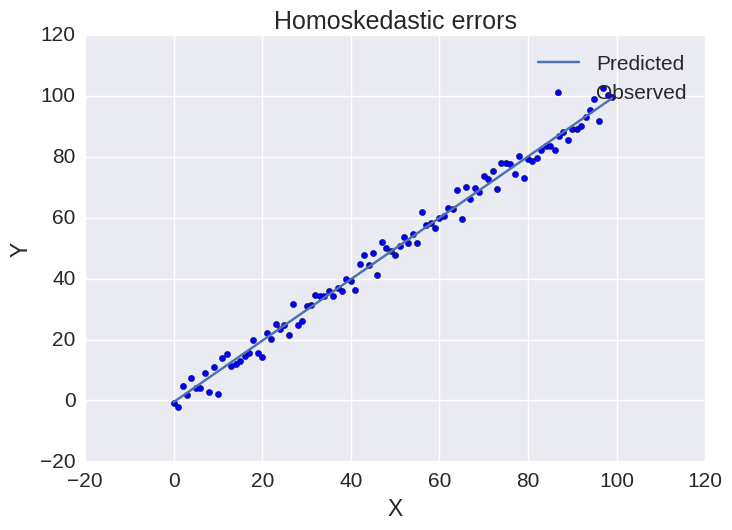

In [58]:
# Artificially create dataset with constant variance around a line
xs = np.arange(100)
y1 = xs + 3*np.random.randn(100)

# Get results of linear regression
slr1 = regression.linear_model.OLS(y1, sm.add_constant(xs)).fit()

# Construct the fit line
fit1 = slr1.params[0] + slr1.params[1]*xs

# Plot data and regression line
plt.scatter(xs, y1)
plt.plot(xs, fit1)
plt.title('Homoskedastic errors');
plt.legend(['Predicted', 'Observed'])
plt.xlabel('X')
plt.ylabel('Y');

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     146.5
Date:                Thu, 19 Jan 2017   Prob (F-statistic):           3.59e-21
Time:                        07:52:39   Log-Likelihood:                -476.29
No. Observations:                 100   AIC:                             956.6
Df Residuals:                      98   BIC:                             961.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -7.8960      5.681     -1.390      0.168       -19.170     3.378
x1             1.2001      0.099     12.105      0.000         1.003     1.397
==============================================================================
Omnibus:                       13.400   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               46.481
Skew:                          -0.041   Prob(JB):                     8.07e-11
Kurtosis:                       6.339   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

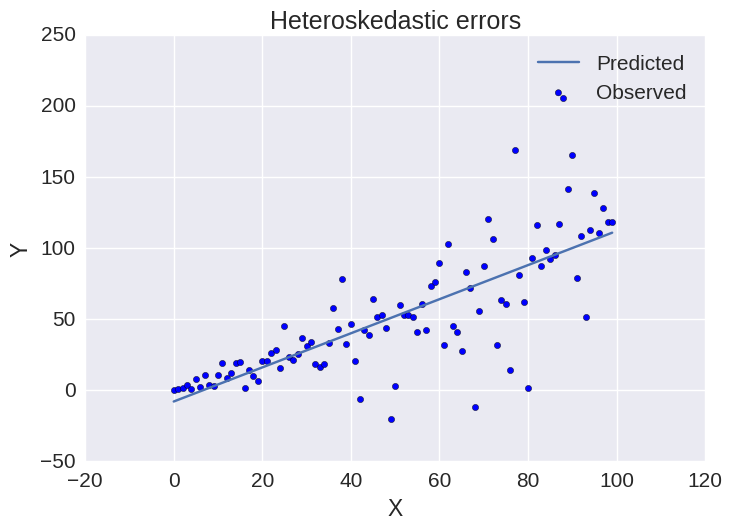

In [59]:
# Artificially create dataset with changing variance around a line
y2 = xs*(1 + .5*np.random.randn(100))

# Perform linear regression
slr2 = regression.linear_model.OLS(y2, sm.add_constant(xs)).fit()
fit2 = slr2.params[0] + slr2.params[1]*xs

# Plot data and regression line
plt.scatter(xs, y2)
plt.plot(xs, fit2)
plt.title('Heteroskedastic errors')
plt.legend(['Predicted', 'Observed'])
plt.xlabel('X')
plt.ylabel('Y')

# Print summary of regression results
slr2.summary()

### Testing for Heteroskedasticity

You can test for heteroskedasticity using a few tests, we'll use the Breush Pagan test from the statsmodels library. We'll also test for normality, which in this case also picks up the weirdness in the second case. HOWEVER, it is possible to have normally distributed residuals which are also heteroskedastic, so both tests must be performed to be sure.

In [60]:
residuals1 = y1-fit1
residuals2 = y2-fit2

xs_with_constant = sm.add_constant(xs)

_, jb_pvalue1, _, _ = statsmodels.stats.stattools.jarque_bera(residuals1)
_, jb_pvalue2, _, _ = statsmodels.stats.stattools.jarque_bera(residuals2)
print ("p-value for residuals1 being normal", jb_pvalue1)
print ("p-value for residuals2 being normal", jb_pvalue2)

_, pvalue1, _, _ = stats.diagnostic.het_breushpagan(residuals1, xs_with_constant)
_, pvalue2, _, _ = stats.diagnostic.het_breushpagan(residuals2, xs_with_constant)
print ("p-value for residuals1 being heteroskedastic", pvalue1)
print ("p-value for residuals2 being heteroskedastic", pvalue2)

p-value for residuals1 being normal 0.690037268661
p-value for residuals2 being normal 8.06837487191e-11
p-value for residuals1 being heteroskedastic 0.837176530519
p-value for residuals2 being heteroskedastic 0.00100419547634


### Correcting for Heteroskedasticity
How does heteroskedasticity affect our analysis? The problematic situation, known as conditional heteroskedasticity, is when the error variance is correlated with the independent variables as it is above. This makes the F-test for regression significance and t-tests for the significances of individual coefficients unreliable. Most often this results in overestimation of the significance of the fit.

The Breusch-Pagan test and the White test can be used to detect conditional heteroskedasticity. If we suspect that this effect is present, we can alter our model to try and correct for it. One method is generalized least squares, which requires a manual alteration of the original equation. Another is computing robust standard errors, which corrects the fit statistics to account for the heteroskedasticity. `statsmodels` can compute robust standard errors; note the difference in the statistics below.

In [61]:
print (slr2.summary())
print (slr2.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     146.5
Date:                Thu, 19 Jan 2017   Prob (F-statistic):           3.59e-21
Time:                        07:52:40   Log-Likelihood:                -476.29
No. Observations:                 100   AIC:                             956.6
Df Residuals:                      98   BIC:                             961.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -7.8960      5.681     -1.390      0.1

# Anscombe's quartet

Anscombe constructed 4 datasets which not only have the same mean and variance in each variable, but also the same correlation coefficient, regression line, and R-squared regression value. Below, we test this result as well as plotting the datasets. A quick glance at the graphs shows that only the first dataset satisfies the regression model assumptions. Consequently, the high R-squared values of the other three are not meaningful, which agrees with our intuition that the other three are not modeled well by the lines of best fit.

In [62]:
from statsmodels import regression

Cofficients: [ 3.00009091  0.50009091] [ 3.00090909  0.5       ] [ 3.00245455  0.49972727] [ 3.00172727  0.49990909]
Pearson r: 0.816420516345 0.816236506 0.81628673949 0.816521436889
R-squared: 0.666542459509 0.666242033727 0.666324041067 0.666707256898


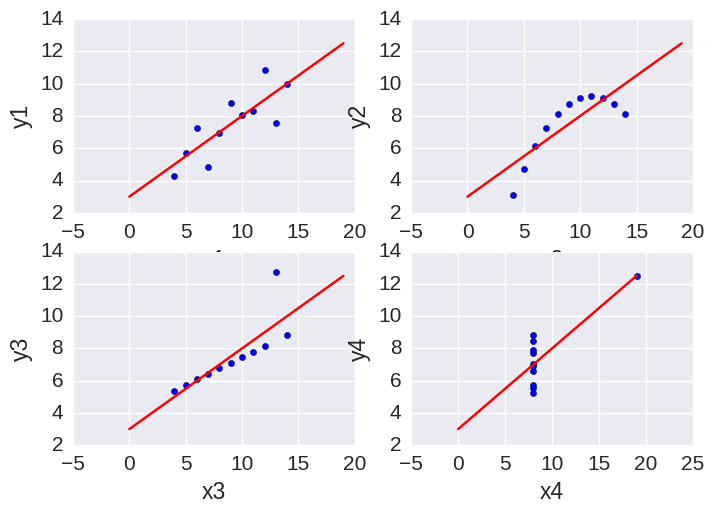

In [63]:
from scipy.stats import pearsonr

# Construct Anscombe's arrays
x1 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
x2 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
x3 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

# Perform linear regressions on the datasets
slr1 = regression.linear_model.OLS(y1, sm.add_constant(x1)).fit()
slr2 = regression.linear_model.OLS(y2, sm.add_constant(x2)).fit()
slr3 = regression.linear_model.OLS(y3, sm.add_constant(x3)).fit()
slr4 = regression.linear_model.OLS(y4, sm.add_constant(x4)).fit()

# Print regression coefficients, Pearson r, and R-squared for the 4 datasets
print ('Cofficients:', slr1.params, slr2.params, slr3.params, slr4.params)
print ('Pearson r:', pearsonr(x1, y1)[0], pearsonr(x2, y2)[0], pearsonr(x3, y3)[0], pearsonr(x4, y4)[0])
print ('R-squared:', slr1.rsquared, slr2.rsquared, slr3.rsquared, slr4.rsquared)

# Plot the 4 datasets with their regression lines
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
xs = np.arange(20)
ax1.plot(slr1.params[0] + slr1.params[1]*xs, 'r')
ax1.scatter(x1, y1)
ax1.set_xlabel('x1')
ax1.set_ylabel('y1')
ax2.plot(slr2.params[0] + slr2.params[1]*xs, 'r')
ax2.scatter(x2, y2)
ax2.set_xlabel('x2')
ax2.set_ylabel('y2')
ax3.plot(slr3.params[0] + slr3.params[1]*xs, 'r')
ax3.scatter(x3, y3)
ax3.set_xlabel('x3')
ax3.set_ylabel('y3')
ax4.plot(slr4.params[0] + slr4.params[1]*xs, 'r')
ax4.scatter(x4,y4)
ax4.set_xlabel('x4')
ax4.set_ylabel('y4');

## Instability
we would like to evaluate the accuracy of the model not by how well it explains the dependent variable, but by how <i>stable</i> it is (that is, how stable the regression coefficients are) with respect to our sample data. After all, if a model is truly a good fit, it should be similar, say, for two random halves of our data set that we model individually. Otherwise, we cannot assume that the model isn't simply an artifact of the particular sample of data we happened to choose, or that it will be predictive of new data points.

We'll be using linear regressions here for illustration purposes, but the same considerations apply for all regression models. Below we define a wrapper function for the linear regression from `statsmodels` so we can use it later.

In [64]:
import numpy as np
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp

def linreg(X,Y):
    # Running the linear regression
    x = sm.add_constant(X) # Add a row of 1's so that our model has a constant term
    model = regression.linear_model.OLS(Y, x).fit()
    return model.params[0], model.params[1] # Return the coefficients of the linear model

### Biased noise

The particular sample we choose for the data affects the model generated, and unevenly distributed noise can lead to an inaccurate model. Below we're drawing from a normal distribution, but because we do not have very many data points, we get a significant downward bias. If we took more measurements, both of the regression coefficients would move toward zero.

Slope: 0.00907250382269 Intercept: -0.402077440853


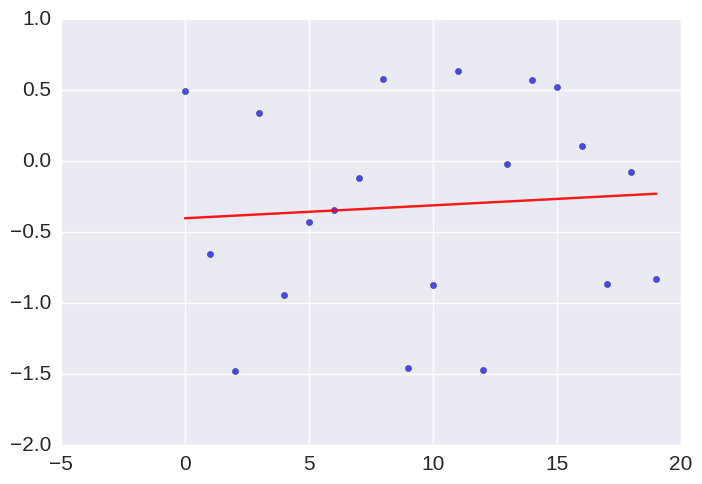

In [65]:
# Draw observations from normal distribution
np.random.seed(107) # Fix seed for random number generation
rand = np.random.randn(20)

# Conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print ('Slope:', b, 'Intercept:', a)

# Plot the raw data and the regression line
plt.scatter(xs, rand, alpha=0.7)
Y_hat = xs * b + a
plt.plot(xs, Y_hat, 'r', alpha=0.9);

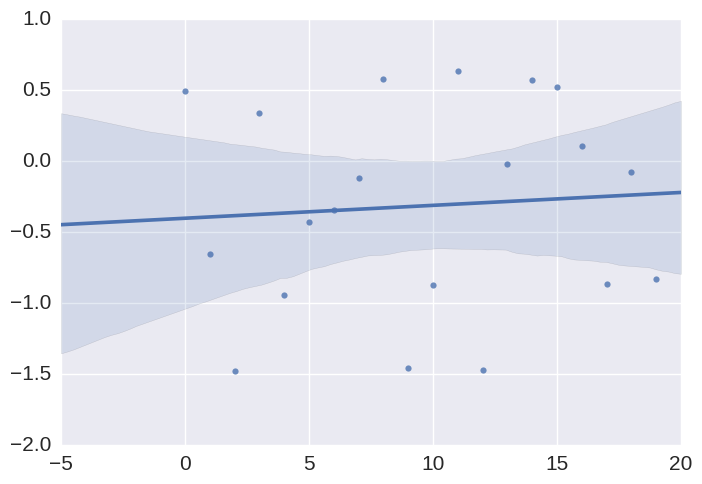

In [66]:
import seaborn

seaborn.regplot(xs, rand)

Slope: -0.000569342363105 Intercept: 0.00901176731902


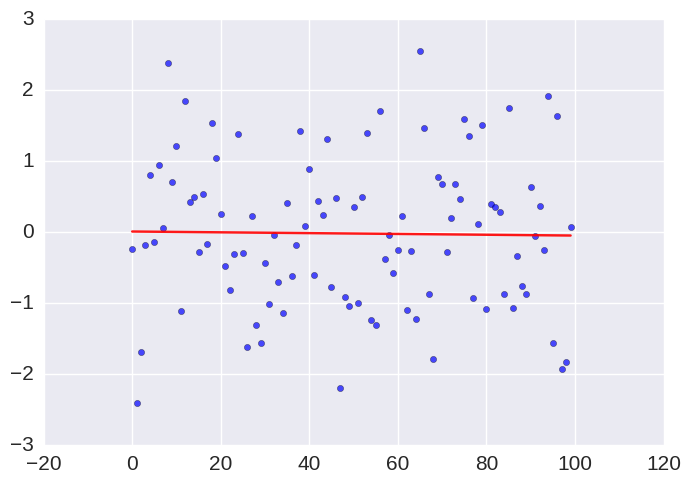

In [67]:
# Draw more observations
rand2 = np.random.randn(100)

# Conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print ('Slope:', b2, 'Intercept:', a2)

# Plot the raw data and the regression line
plt.scatter(xs2, rand2, alpha=0.7)
Y_hat2 = xs2 * b2 + a2
plt.plot(xs2, Y_hat2, 'r', alpha=0.9);

Regression analysis is very sensitive to outliers. Sometimes these outliers contain information, in which case we want to take them into account; however, in cases like the above, they can simply be random noise. Although we often have many more data points than in the example above, we could have (for example) fluctuations on the order of weeks or months, which then significantly change the regression coefficients.